In [1]:
import time

import numpy as np
from scipy.constants import g as gravity
from inspect import signature
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from visualisation import Animation

from bokeh.plotting import figure
from bokeh.layouts import layout
from bokeh.io import show, output_notebook, push_notebook
from bokeh.models import ColumnDataSource, LabelSet, Label
from bokeh.models.renderers import GlyphRenderer
from bokeh.models.glyphs import ImageURL
output_notebook()

simulate_examples=False

from systools import PendelWagenSystem
from lmntools import LMNRegressor
from plot import PlotterLLM

if simulate_examples:
    from systools import Simulator, PendelWagenSystem
    from functions import spline_func_gen
    from lmntools import LMNRegressor

Loading BokehJS ...

In [2]:
from ipywidgets import interact_manual, FloatSlider, widgets
from IPython.display import display, Markdown, Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

#display(HTML("<style>.container { width:100% !important; }</style>"))

#### Philipp Woller

## VERGLEICH VON METHODEN DES MASCHINELLEN LERNENS UND KLASSISCHER ANSÄTZE ZUR TRAJEKTORIENPLANUNG DYNAMISCHER SYSTEME
##### Dresden, 14. Dezember 2018
<!-- .slide: style="text-align: left;"> -->  

In [3]:
parameter_values = dict(g=gravity, m1=1, m2=0.1, l=0.5)
sys = PendelWagenSystem()
if simulate_examples:
    model = sys.get_sim_model(parameter_values)

## Gliederung


- Motivation


- Beispielsystem

- Ansätze zur Datenerzeugung

- Einsatz künstlicher neuronaler Netze

- Einsatz lokale Modellnetze

- Zusammenfassung und Ausblick

## Motivation
### Trajektorienplanung

- _Überführung eines regelungstechnischen Systems von einem gegebenen Anfangszustand $x(t=0)$ in einen gewünschten Endzustand $x(t=T)$ in endlicher Zeit $T$ mithilfe eines geplanten Stellgrößenverlaufs_

- Anwendung 
    - Positionswechsel in der Robotik
    - Anfahrvorgänge und Lastwechsel bei Prozessen der Verfahrenstechnik


- nichtlineare dynamische Randwertaufgabe (RWA) $\rightarrow$ z.B. Lösung über Kollokationsverfahren

## Motivation
### Maschinelles Lernen

- Lernsystem $\rightarrow$ Generalisierung der Lösung mit datengetriebenen Methoden
    - Reduktion der benötigten Rechenleistung
    - Anpassbarkeit

- Übersicht:

| <font color='grey'>Unüberwachtes Lernen</font> | Überwachtes Lernen | <font color='grey'>Bestärkendes Lernen</font> |  
| -------------------- | ------------------ | ------------------- | 
| <font color='grey'>Dimensionsreduktion<br/>Clusteranalyse</font>  | <font color='grey'>Klassifikation $(y \in \mathbb{Z})$</font><br/>Regression $(y \in \mathbb{R})$  | <font color='grey'>Interaktion eines lernenden Agenten<br/>mit seiner Umwelt</font> |    


- der Agent erlernt selbständig eine Strategie, um erhaltene Belohnungen zu maximieren

## Pendel-Wagen-System (PWS)
<table width="100%"><tr>
<td width="50%"> <center><img src="img/pendel_wagen_.svg" width="400" height="400"></center> </td>
<td width="50%"> <center><p style="font-size:26px">Systemgleichung in partiell linearisierter Form:</p></center> <br> $\dot{\mathbf{z}} = \begin{pmatrix} \dot{\varphi} \\ \dot{q} \\ \frac{g \sin \varphi}{l} \\ 0\end{pmatrix} + \begin{pmatrix} 0 \\ 0 \\ \frac{\cos \varphi}{l} \\ 1 \end{pmatrix} \cdot \ddot{q}$</td>
</tr></table>

<center>
$\mathbf{z}(T) = \mathbf{\Omega}(u(\mathbf{p}), \mathbf{z}(0)) \quad \text{mit}  \quad \mathbf{z}=\begin{pmatrix} \varphi \\ q \\ \dot{\varphi} \\ \dot{q} \end{pmatrix}, t \in [0, T]$
</center>

## _Funktion_ für die Trajektorienplanung
<section>
<div style="position:relative; width:650px; height:400px; margin:0 auto;">
  <img class="fragment fade-out" data-fragment-index="0" width="660" height="550" src="img/parameter_abbildung1.svg" style="position:absolute;top:0;left:0;" />
  <img class="fragment fade-in" data-fragment-index="0" width="660" height="550" src="img/parameter_abbildung2.svg" style="position:absolute;top:0;left:0;" /> 
</div>
</section>

- Für die Trajektorienplanung wird die Umkehrfunktion $\Omega^{-1}$ benötigt  
- $\Omega^{-1}(\mathbf{z}(T)) = \Gamma(\mathbf{z}(T)) = \mathbf{p} \quad $ mit $ \quad \mathbf{x}(0) = \mathbf{0}$
- Modellierung des Eingangsverlaufs $u(\mathbf{p})$ mit Splines
- Datenerzeugung durch Simulation des Anfangswertproblem

X - Eingangsraum  
Y - Ausgangsraum

In [4]:
display(Markdown("## Datenerzeugung"))
display(Markdown("### Beispiel: Seitliches Versetzen des PWS"))
param = [-0.14462256,  0.64411273]

if simulate_examples:
    func_1 = spline_func_gen(kind=5, diff=2, bc_type=[[(1, 0), (2, 0)], [(1, 0), (2, 0)]])
    sim_1 = Simulator(model, x0=[0.0, 0.0, 0.0, 0.0], t0=0.0, T=1.0, input_func_gen=func_1,
                      func_parameters={'n': 2, 'start_end': (0.0, 0.5)})
    res_1 = sim_1.solve(param, use_sp2c=True, additional_time=0.0)

    np.save("res_1.npy", (res_1, (0,)) )
else:
    res_1, *_ = np.load("res_1.npy")

animation_model_1 = sys.get_animation_model(l=0.5)
fig1_1 = figure(x_range=[-0.2, 0.7], y_range=[-0.15, 0.65], width=530, height=550)
fig1_1.toolbar.logo = None
fig1_1.toolbar_location = None
fig1_1.yaxis.visible = False
fig1_1.title.text_font_size = '16pt'
fig1_1.xaxis.axis_label = 'Wagenposition in m'
fig1_1.xaxis.axis_label_text_font_size = '16pt'
fig1_1.min_border_right = 50

fig2_1 = figure(y_range=[-0.3, 0.8],width=675, height=550, title='Verlauf der Wagenposition q')
fig2_1.toolbar.logo = None
fig2_1.toolbar_location = None
fig2_1.title.text_font_size = '16pt'

fig2_1.line(res_1[1], res_1[0].T[1], line_width=2.5, color='black')
fig2_1.xaxis.axis_label = 't in s'
fig2_1.yaxis.axis_label = 'q in m'#/s²'
fig2_1.xaxis.axis_label_text_font_size = '16pt'
fig2_1.yaxis.axis_label_text_font_size = '16pt'

source = ColumnDataSource(data=dict(x=np.linspace(0, 1, 4),
                                    y=[0, *param, 0.5],
                                    names=['p1', 'p2', 'p3', 'p4']))
names=['p1', 'p2', 'p3', 'p4']
fig2_1.x(x='x', y='y', source=source, size=16, line_width=3, color='red')

for (x, p, off, name) in zip(np.linspace(0, 1, 4), [0, *param, 0.5], [0, 0, 0, 0], names):
    label = Label(x=x, y=p, text=name, level='glyph', x_offset=-8, y_offset=12+off, render_mode='canvas')

    fig2_1.add_layout(label)


ani_1 = Animation(sim_data=res_1, image=animation_model_1, fig=fig1_1)
fig_layout_1 = layout([[ani_1.figure, fig2_1]])
target_1 = show(fig_layout_1, notebook_handle=True)
def animation_1(k):
    ani_1.animate(target_1, speed_factor=k)
interact_manual(animation_1, k=FloatSlider(value=0.25, min=0.1, max=1.0, step=0.05));

## Datenerzeugung

### Beispiel: Seitliches Versetzen des PWS

interactive(children=(FloatSlider(value=0.25, description='k', max=1.0, min=0.1, step=0.05), Button(descriptio…

### Datenerzeugung mittels Rasterung des Eingangsrraums
<section>
<div style="position:relative; width:900px; height:900px; margin:0 auto;">
<img class="fragment current-visible" src="datenerzeugung/sv_1.svg" width="900" height="900" style="position:absolute;top:0;left:0;" />
<img class="fragment current-visible" src="datenerzeugung/sv_2.svg" width="900" height="900" style="position:absolute;top:0;left:0;" />
<img class="fragment current-visible" src="datenerzeugung/sv_3.svg" width="900" height="900" style="position:absolute;top:0;left:0;" />
<img class="fragment current-visible" src="datenerzeugung/sv_4.svg" width="900" height="900" style="position:absolute;top:0;left:0;" /> 
<img class="fragment current-visible" src="datenerzeugung/sv_final.svg" width="900" height="900" style="position:absolute;top:0;left:0;" /> 
</div>
</section>

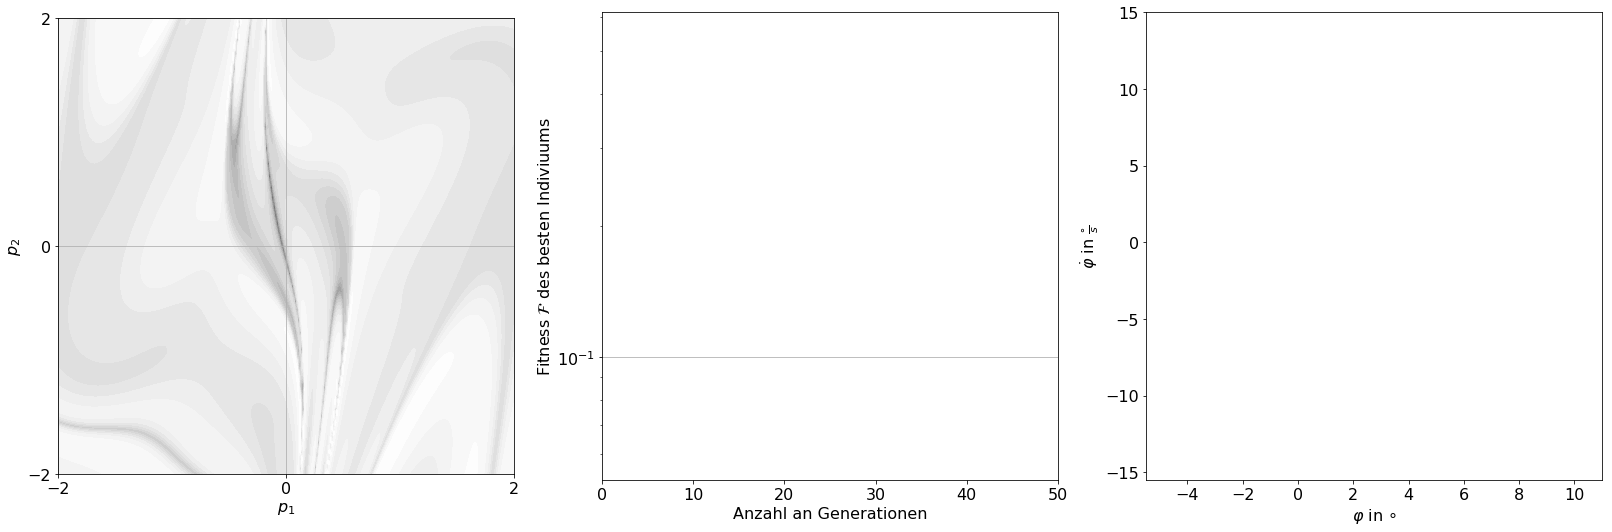

In [5]:
dv, x, log = np.load('de/log_generations.npy')
DV = np.split(dv, 51)
X = np.split(np.rad2deg(x), 51)

log = np.vstack((log[0], log))

surface_data_glob = np.load('de/PW_POS_GLOB_0.5.npy')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22.5, 7.5))
ax = axes.flatten()

ax[0].set_xlim((-2, 2))
ax[0].set_ylim((-2, 2))
ax[0].xaxis.set_major_locator(plt.MaxNLocator(2))
ax[0].yaxis.set_major_locator(plt.MaxNLocator(2))
ax[0].set_xlabel("$p_1$")
ax[0].set_ylabel("$p_2$")
ax[0].set_aspect(1)
ax[0].grid()
line0, = ax[0].plot([], [], marker='x', linestyle='', markersize=8, color='#00305e')
ax[0].contourf(surface_data_glob[0], surface_data_glob[1],
               np.log(surface_data_glob[2].reshape(surface_data_glob[0].shape)),
               25, cmap='Greys_r', alpha=1.0)


ax[1].set_xlabel("Anzahl an Generationen")
ax[1].set_ylabel(r"Fitness $\mathcal{F}$ des besten Indiviuums")
ax[1].set_yscale("log", nonposy='clip')
ax[1].grid(axis='y')
ax[1].set_xlim([0, 50])
ax[1].set_ylim([np.min(log[:, 2])*0.9, np.max(log[:, 2])*1.1])
line1, = ax[1].plot([], [], lw=4, color='#00305e')


line2, =ax[2].plot([], [], marker='x', linestyle='', markersize=8, color='#00305e')

#ax[2].contourf(x1, x2, F_, n_levels, cmap='Greys_r', alpha=0.5)
ax[2].set_xlabel(r"$\varphi$ in $\circ$")
ax[2].set_ylabel(r"$\dot{\varphi}$ in $\frac{\circ}{s}$")
ax[2].axhline(0, color='white', linewidth=1.5/4, alpha=0.5)
ax[2].axvline(0, color='white', linewidth=1.5/4, alpha=0.5)
ax[2].set_xlim([-5.5, 11])
ax[2].set_ylim([-15.5, 15])

plt.tight_layout()

# initialization function: plot the background of each frame
def init():
    line0.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    return (line0, line1, line2)

# animation function. This is called sequentially
def animate(i):
    j = i % 51
    line0.set_data(*DV[j].T)
    line1.set_data(log[0:j+1, 0], log[0:j+1, 2])
    line2.set_data(*X[j][:, [0, 2]].T)
    ax[0].set_title("Generation Nr." + str(j).zfill(2), fontsize=16, weight='bold', loc='left')
    return (line0, line1, line2)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=51, interval=100, blit=True);

In [11]:
display(Markdown("## Datenerzeugung mittels Differentialevolution (DE)"))
HTML(anim.to_jshtml())

## Datenerzeugung mittels Differentialevolution (DE)

## Künstliche neuronale Netze mit mehrlagigen Perzeptren

<table width="100%"><tr>
<td width="50%"> <center><section>
<div style="position:relative; width:700px; height:450px; margin:0 auto;">
<img class="fragment current-visible" src="img/perzeptron.svg" width="700" height="450" style="position:absolute;top:0;left:0;" />
<img class="fragment current-visible" src="img/mlp.svg" width="700" height="450" style="position:absolute;top:0;left:0;" />
</section></center> </td>
<td width="50%"> <center><p style="font-size:40px">
    • Verarbeitungseinheit Neuron (Perzeptron): $\mathcal{A} = \Phi(\mathbf{w}^T \cdot \mathbf{u} + w_0)$<br/>• Hyperparameter:<br/>$\quad$▪ Netzstruktur (Breite/Tiefe)<br/>$\quad$▪ Aktivierungsfunktion $\Phi$<br/>$\quad$▪ Netzstruktur (Breite/Tiefe)<br/>$\quad$▪ Trainingsdauer (Epochen)</p></center> </td>
</tr></table>

<center>
    
</center>

## Lokale Modellnetze
### Grundidee


- $M$ einfache (lokale) Modelle durch Regression bestimmen
- Modellausgang $\hat{=}$ gewichtete Summe der Ausgänge $y_i$ der Teilmodelle
$$y = \sum_{i=1}^{M} y_i(x) \cdot \Phi_i (x)$$
- Typischerweise $\Phi_i(\cdot)$ Gaußfunktionen (radiale Basisfunktionen)

## Interpretation als Netzstruktur

<center>
    <img src="img/lmn.svg" width="800" height="800">
</center>

## LOLIMOT

- "Lokalität" muss gelernt werden $\rightarrow$ Ansatz: __LO__cal __LI__near __MO__del __T__ree  
- __Iteration:__
    - Schlechtestes Teilmodell finden
    - Achsen-orthogonale Teilungen in jeder Dimension $\rightarrow$ beste Teilung übernehmen
    - Abbruchkriterien z.B. maximale Anzahl an Teilmodellen, globaler (Trainings-)Fehler
    - Ein neues Teilmodell in jedem Durchgang

<center>
    <img src="img/lolimot.svg" width="900" height="600">
</center>

In [7]:
# Benutzerdefnierte Funktionen
functions=dict(
    arctan=lambda u: 3 * np.arctan(2*u) + 5,
    poly=lambda u: (4+u)*(u+1)*(u-1)*(u-3)/14,
    trigonometric=lambda u: np.sin(2*np.pi*u/4) + 0.5 * np.cos(2*np.pi*u),
    sin=lambda u: 2*np.sin(u),
    affensattel=lambda u1, u2: (u1**3 - 3 * u1 * u2**2 ) / 200,
    dipl=lambda u: np.sin(10 * np.exp(-2*u)) * np.exp(-2*u))

In [8]:
display(Markdown("## Aufgabe: Aufschwingen des PWS"))

params = np.array([[ -8.34143496,  14.95923772,  -9.25091965,   2.64434211],
                   [ -7.24751224,  14.95564424, -10.35264979,   2.64659942],
                   [ -6.20327186,  15.08227582, -11.5545351 ,   2.67564621],
                   [ -5.20871383,  15.33403987, -12.85657558,   2.7314825 ],
                   [ -4.26383815,  15.70722476, -14.25877124,   2.81410829]])

if simulate_examples:
    func_2 = spline_func_gen(kind=1, diff=0)
    sim_2 = Simulator(model, x0=[np.pi, 0.0, 0.0, 0.0], t0=0.0, T=2.0, input_func_gen=func_2,
                      func_parameters={'n': 4})
    ress = [sim_2.solve(p, use_sp2c=True, additional_time=0.0) for p in params]
    np.save("ress.npy", [ress, (0, )])
else:
    ress, *_ = np.load("ress.npy")
    
animation_model_2 = sys.get_animation_model(l=0.5)

fig1_2 = figure(x_range=[-1.2, 1.0], y_range=[-0.54, 0.54], width=1320, height=650)#, title='Pendel-Wagen-System')
fig1_2.toolbar.logo = None
fig1_2.toolbar_location = None
fig1_2.yaxis.visible = False
fig1_2.title.text_font_size = '16pt'
fig1_2.xaxis.axis_label = 'Wagenposition in m'
fig1_2.xaxis.major_label_text_font_size = '14pt'
fig1_2.xaxis.axis_label_text_font_size = '16pt'
fig1_2.min_border_right = 50

ani_2 = Animation(sim_data=ress[0], image=animation_model_2, fig=fig1_2)
data_source=ColumnDataSource(dict(url=["aufschwingen/pws_0.png"]))
img = fig1_2.image_url(url='url', x=-1.2, y=0.54, w=None, h=None, source=data_source, global_alpha=0.5)
img.level = 'underlay'
fig_layout_2 = layout([[fig1_2]])
target_2 = show(fig_layout_2, notebook_handle=True)

def animation_2(k):
    for i, res in enumerate(ress):
        ani_2.set_sim_data(res)
        ani_2.animate(target_2, speed_factor=k)
        img.data_source.data.update(dict(url=[f"aufschwingen/pws_{i+1}.png"]))

interact_manual(animation_2, k=FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1));

## Aufgabe: Aufschwingen des PWS

interactive(children=(FloatSlider(value=0.5, description='k', max=1.0, min=0.1), Button(description='Run Inter…

In [9]:
display(Markdown("## Beispiel - Lokale Modellnetze"))
np.random.seed(42)
rand = False

def lolimot(model_complexity, p, local_model, net):
    x_range = [-5, 5]
    func = functions['arctan']
    k = 21
    
    # TRAINING
    
    llm = LMNRegressor(network=net, local_models=local_model, model_complexity=model_complexity,
                       random_state=42, smoothness=p, optimization='local')
    #llm.network.smoothness = p
    
    N = len(signature(func).parameters)
    k = int(np.power(k, 1/N).round())
    k_pred = int(np.clip(k**(2/N), a_min=1, a_max=10000))
    
    if rand:
        X_train = np.random.uniform(low=x_range[0], high=x_range[1], size=k).reshape(k, 1)
    else:
        X_train = np.reshape(np.linspace(x_range[0], x_range[1], k), (k, 1))
    y_train = func(X_train).ravel()
    _ = llm.fit(X_train, y_train)

    # PLOT
    X_test = np.reshape(np.linspace(x_range[0], x_range[1], k_pred), (k_pred, 1))
    y_test = func(X_test)
        
    plotter = PlotterLLM(options=["result", "validity_function", "models"], sort=False)
    plotter.update(X_test, y_test, X_train, y_train, llm)
    plt.tight_layout()

# Widgets
complexity_range = widgets.IntSlider(
    continuous_update=False, min=1, max=50, value=8,
    layout=widgets.Layout(width='90%'),
    description="complexity")
p_range = widgets.FloatSlider(
    continuous_update=False, min=0.05, max=1.5,
    value=0.33, step=0.01, layout=widgets.Layout(width='90%'))

local_model = widgets.ToggleButtons(options=['const', 'linear', 'quadratic', 'cubic'],
                                    description='local model:', disabled=False)

net = widgets.ToggleButtons(options=['grid', 'lolimot'], description='network:', disabled=False)

interact_manual(lolimot, model_complexity=complexity_range, 
                p=p_range, local_model=local_model, net=net);

## Beispiel - Lokale Modellnetze

interactive(children=(IntSlider(value=8, continuous_update=False, description='complexity', layout=Layout(widt…

### Trajektorienplanung für Aufschwingen des PWS
<center>
    <img src="img/pop.png">
</center>

## Zusammenfassung und Ausblick

- Einblick in die Trajektorienplanung für dynamische Systeme
- Vorstellung der lokalen Modellnetze für die Funktionsapproximation

#### Offenen Fragen
- Datenerzeugung
- Anforderungen an den Datensatz

#### Ausblick
- Iterative Verbesserung („Online-Lernen“)
- Mehr Freiheitsgrade, komplexere Systeme